In [108]:
# !pip uninstall scikit-learn  -y
# !pip install --upgrade category-encoders

# !pip install scikit-learn==1.6.1 -q


# LSTM and Google Stock Prediction 📈

## 🔹 What is LSTM?
Long Short-Term Memory (LSTM) is a type of **Recurrent Neural Network (RNN)** that is well-suited for handling **time-series data** such as stock prices. Unlike standard RNNs, LSTM has **memory cells** that can retain important information for long periods, making it highly effective for predicting sequential data.

### ✅ Key Features of LSTM:
- **Memory Cells**: Store past information to understand trends.
- **Forget Gate**: Decides which information should be discarded.
- **Input Gate**: Determines what new information should be added.
- **Output Gate**: Controls the final output of the cell.

Because stock prices depend on historical trends, LSTM is a powerful tool for forecasting future movements. 📊

---

## 🔹 Why Predict Google Stock (GOOG)?
- **Alphabet Inc. (Google)** is one of the most valuable companies worldwide.
- Google stock data is **publicly available** and frequently analyzed by investors.
- The stock exhibits **trends, volatility, and seasonal patterns**, making it a perfect dataset for testing deep learning models.

Using LSTM, we aim to predict **Google's closing stock price** and compare our predictions with actual market values. This helps **investors and traders** make informed decisions. 🚀

---

## 🔹 Our Approach
1️⃣ **Load Data** – Import historical stock prices.  
2️⃣ **Preprocess Data** – Normalize, clean, and structure the dataset.  
3️⃣ **Build an LSTM Model** – Train a deep learning model using past stock prices.  
4️⃣ **Make Predictions** – Forecast future closing prices based on trained data.  
5️⃣ **Visualize Results** – Compare predicted prices with actual stock prices using **Matplotlib & Plotly**.  

Through this step-by-step process, we will gain insights into **how AI can assist in financial analysis**. 📉📈


![](https://miro.medium.com/v2/resize:fit:984/1*Mb_L_slY9rjMr8-IADHvwg.png)

[](https://th.bing.com/th/id/OIP.qSGP0gJr0O0BdOpvFX_UdAHaGN?rs=1&pid=ImgDetMain)

## Importing Required Libraries

To build and train our LSTM model, we need several essential Python libraries:

- **NumPy**: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions.
- **Pandas**: Used for data manipulation and analysis, particularly useful for handling time-series stock market data.
- **Matplotlib**: A visualization library for creating plots, which helps in analyzing and comparing stock prices.
- **Scikit-learn (MinMaxScaler)**: Used for normalizing the dataset to bring all values between a specific range (0 to 1) to improve model performance.
- **Keras (Sequential, LSTM, Dropout, Dense)**:
  - `Sequential`: A linear stack of layers for building deep learning models.
  - `LSTM`: Long Short-Term Memory, a specialized form of recurrent neural networks (RNN) designed for sequential data.
  - `Dropout`: A regularization technique to prevent overfitting by randomly ignoring some neurons during training.
  - `Dense`: A fully connected layer that serves as the output layer in our LSTM model.

The following code imports all the necessary libraries:

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

## 📥 Loading Google Stock Data  
In this step, we load the historical stock price data of Google (GOOG) from a CSV file.  
The dataset contains information such as **Open, High, Low, Close, and Volume** from **January 1, 2010, to February 4, 2025**.

In [110]:
goog = pd.read_csv("/kaggle/input/google-stock-1jan2010-4feb2025/GOOG_stock_data_2010_2025.csv")


In [111]:
goog.head()

,Date,Close,High,Low,Open,Volume
0,2010-01-04,15.554352,15.622847,15.492059,15.559315,78541293
1,2010-01-05,15.485854,15.581401,15.425051,15.565021,120638494
2,2010-01-06,15.095475,15.532262,15.048322,15.532262,159744526
3,2010-01-07,14.744060,15.138658,14.708074,15.123767,257533695
4,2010-01-08,14.940616,14.971141,14.620222,14.691944,189680313


## 🔍 Checking for Missing Values  
Before processing the data, it's essential to check if there are any missing values.  
The following command returns `True` for any column that contains missing values, helping us decide if data cleaning is necessary.


In [112]:
goog.isnull().any()

Date      False
Close     False
High      False
Low       False
Open      False
Volume    False
dtype: bool

In [113]:
goog.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## 📏 Data Normalization using MinMaxScaler  
Since LSTM models perform better with scaled data, we normalize the stock prices between 0 and 1 using `MinMaxScaler`.  
This ensures that all features are within the same range, improving model performance.

![](https://miro.medium.com/v2/0*HFa_v2GJQMtwkru1.png)

In [114]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(goog[['Close', 'Open', 'High', 'Low', 'Volume']].values)

## 🔄 Creating Features and Labels for LSTM Model  
To train our LSTM model, we need to convert the time series data into sequences of past observations (features) and corresponding target values (labels).

![](https://www.researchgate.net/publication/355186549/figure/fig1/AS:1078519215992841@1634150427276/Sliding-window-technique-for-cutting-the-initial-time-series-into-fixed-length-samples.png)

The algorithm used here is **Sliding Window (Rolling Window) Method**, which is commonly used for **time series forecasting**.  

### 🔹 **Algorithm Name: Sliding Window Method**
This technique structures time-series data into overlapping sequences, allowing models like **LSTM** to learn temporal patterns effectively.  

#### ✅ **Key Idea**:  
For each prediction, the model looks at a fixed number of previous time steps (**window size**) to forecast the next value.  

#### 🔄 **Example:**
If `time_step = 30`, the model will use the **past 30 days** of stock prices to predict the **31st day’s closing price**.

This method is widely used in **stock price prediction, weather forecasting, and anomaly detection**. 🚀

In [115]:
def create_features_labels(data, time_step=60):
    features, labels = [], []
    for i in range(time_step, len(data)):
        features.append(data[i-time_step:i]) 
        labels.append(data[i, 0])  
    return np.array(features), np.array(labels)

X, y = create_features_labels(scaled_data, time_step=30)

## 📌 **Train-Test Split (80-20 Rule)**
This section of the code splits the dataset into **training** and **testing** sets, which is crucial for evaluating the model's performance.

#### ✅ **How It Works:**
- `train_size = int(len(X) * 0.8)`:  
  - Computes **80%** of the dataset size for training.
- `X_train, X_test = X[:train_size], X[train_size:]`:  
  - The **first 80%** of `X` is used for **training**, and the **remaining 20%** for **testing**.
- `y_train, y_test = y[:train_size], y[train_size:]`:  
  - The **target values** (`y`) are also split accordingly.

#### 🎯 **Why Use Train-Test Splitting?**
- **Prevents overfitting**: Ensures the model generalizes well to unseen data.
- **Provides evaluation metrics**: Allows performance assessment on **new (unseen) data**.
- **Common practice in machine learning**: Helps in **model validation and fine-tuning**.

This method follows the **80-20 rule**, but in some cases, a **70-30 or 90-10 split** can also be used. 🚀

In [116]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 🏗️ **Building the LSTM Model**  

The following line initializes a **sequential model** in Keras:  

```python
model = Sequential()
```

#### ✅ **What is a Sequential Model?**
- The **Sequential API** in Keras allows you to **stack layers** one after another in a **linear** fashion.
- It is **easy to use** and **suitable for most deep learning models**, including LSTMs.
- Each layer is added **sequentially**, defining the **flow of data** through the network.

#### 🎯 **Why Use Sequential?**
- Ideal for **feedforward** neural networks, including **LSTMs**.
- Simple and intuitive for **prototyping** deep learning models.
- Works well for **time series forecasting** where the data flows through a series of LSTM layers.

After initializing the model, we will **add LSTM layers** and define the structure of our neural network. 🚀

In [117]:
model = Sequential()

## 🔥 **Adding LSTM Layers to the Model**  

Now, we add **LSTM (Long Short-Term Memory) layers** and **Dropout layers** to our model.  

---

### 🏗️ **Breaking Down the Architecture:**
#### ✅ **1. First LSTM Layer**
```python
model.add(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
```
- **300 units**: Determines the number of LSTM neurons in this layer.
- **`return_sequences=True`**: This ensures that the layer outputs a sequence, allowing it to pass data to the next LSTM layer.
- **`input_shape=(X_train.shape[1], X_train.shape[2])`**: Defines the shape of input data (time steps, features).

#### ✅ **2. Dropout Layer**
```python
model.add(Dropout(0.2))
```
- **Prevents overfitting** by randomly setting 20% of the neurons to zero during training.

#### ✅ **3. Additional LSTM Layers**
```python
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
```
- **100 units** in each layer to capture patterns in the time series.
- **Keeping `return_sequences=True`** to pass sequence output to the next LSTM layer.

#### ✅ **4. Final LSTM Layer**
```python
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
```
- **`return_sequences=False`**: Since this is the last LSTM layer, it outputs a single value instead of a sequence.

#### ✅ **5. Output Layer (Dense Layer)**
```python
model.add(Dense(units=1))
```
- Outputs a **single predicted value** (stock price prediction).

In [118]:
model.add(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



## 📜 **Model Summary**  

The `model.summary()` function provides a structured overview of our **LSTM model architecture**, including:  

✔️ **Layer types** (LSTM, Dropout, Dense)  
✔️ **Number of parameters** in each layer  
✔️ **Output shape** at each step  

### 🏗 **Breaking Down the Model Summary:**
- **LSTM (Long Short-Term Memory) layers**: Capture time-series dependencies.  
- **Dropout layers**: Prevent overfitting by randomly deactivating neurons.  
- **Dense layer**: Outputs the final predicted stock price.  
- **Total parameters**: Represents the number of trainable weights and biases in the model.  

📌 This summary helps us understand the structure, complexity, and computational cost of our model. 🚀

In [119]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                       │ (None, 30, 300)             │         367,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 30, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ (None, 30, 100)             │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_74 (LSTM)                       │ (None, 30, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_75 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688,501 (2.63 MB)

 Trainable params: 688,501 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

## ⚙ **Compiling the LSTM Model**  

Before training the model, we need to compile it by specifying:  
✔ **Optimizer** – Defines how the model updates weights during training.  
✔ **Loss Function** – Measures the difference between predicted and actual values.  

---

#### 🛠 **Code Explanation:**  
```python
model.compile(optimizer='adam', loss='mean_squared_error')
```

#### 🔍 **What Each Parameter Does?**
- **`optimizer='adam'`**  
  - The **Adam (Adaptive Moment Estimation)** optimizer is used to adjust learning rates dynamically.  
  - It combines benefits of **Momentum** and **RMSprop** optimizers.  
  - Works well for time-series and deep learning models.  
   
- **`loss='mean_squared_error'`**  
  - The **Mean Squared Error (MSE)** is a common loss function for regression problems.  
  - It calculates the average squared difference between predicted and actual values.  
  - Lower **MSE** → Better predictions.  

---

### 🔥 **Why Adam and MSE?**
✅ **Adam** is efficient, requires little tuning, and adapts learning rates dynamically.  
✅ **MSE** is a good choice for continuous-value predictions like stock prices.  

After this step, the model is **ready for training!** 🚀

In [120]:
model.compile(optimizer='adam', loss='mean_squared_error')

## 🧑‍💻 Training the Model 

We will train the model using the `fit` method. The model will be trained on the training data (`X_train`, `y_train`) for 75 epochs ⏳, with a batch size of 128 🧠.

- `epochs=75` ⏳: The model will go through the training data 75 times.
- `batch_size=128` 🧠: The model will use batches of 128 samples for each update of the weights during training.

This process will help the model learn from the data and improve its predictions over time 📈.

In [121]:
model.fit(X_train, y_train, epochs=75, batch_size=128)

Epoch 1/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0193
Epoch 2/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 3/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9921e-04
Epoch 4/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1001e-04
Epoch 5/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1369e-04
Epoch 6/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2825e-04
Epoch 7/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3422e-04
Epoch 8/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2085e-04
Epoch 9/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7149e-04
Epoch 10/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1970e-04
Epoch 11/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0345e-04
Epoch 12/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9317e-04
Epoch 13/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.8895e-04
Epoch 14/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.8587e-04
Epoch 15/75
24/24 ━━━━━

## 🔮 Making Predictions 

After training the model, we can use it to make predictions on the test data (`X_test`).

- `model.predict(X_test)` 🔮: The model generates predictions for the test data (`X_test`). These predictions can be compared with actual values to evaluate the model’s performance.

This step allows us to assess how well the model generalizes to unseen data 📊.

In [122]:
predictions = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


## 🔄 Rescaling Predictions and Actual Values 

To rescale the predictions and actual values back to their original scale, we use the `inverse_transform` method of the scaler. We append zeros to match the expected input shape for the scaler.

- `scaler.inverse_transform(...)` 🔄: This reverses the scaling operation and converts the predictions and actual values back to their original range.
- `np.concatenate(...)` 🔗: We concatenate zeros to the predictions and actual values to match the input shape required by the scaler (ensuring other features are correctly accounted for).
- `[:, 0]` 🎯: This selects only the first column (the actual value or prediction) after the transformation.

This step is important for evaluating the model’s performance in the original scale of the data 📊.

In [123]:
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

## 📊 Visualizing the Predictions 

To visualize the performance of the model, we plot the actual and predicted stock prices over time. This helps to compare how closely the model's predictions align with the actual values.

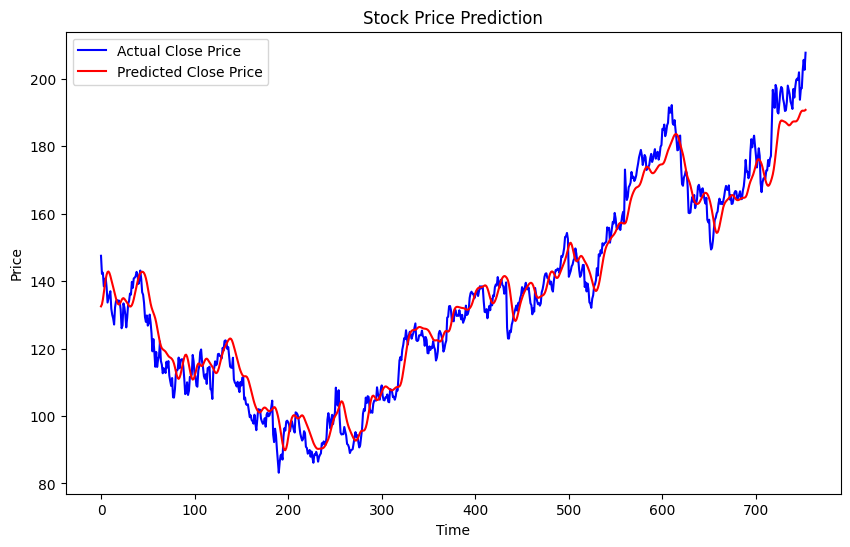

In [124]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual Close Price', color='blue')
plt.plot(predictions_rescaled, label='Predicted Close Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 🗃️ Saving the Model 

After training the model, it's important to save it so that you can load and use it later without retraining. In this example, we use the `pickle` module to save the model.

In [125]:
import pickle

# Save the model
with open('LSTM_model_GOOG_stock.pkl', 'wb') as f:
    pickle.dump(model, f)

In [126]:
# Load the model
# with open('my_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)



## 📈 Stock Price Prediction with New Data 

In this section, we use the trained LSTM model to predict Google stock prices based on new data. The data is first loaded, scaled, and then predictions are made. Finally, we compare the actual and predicted prices.

- **Loading the Data** 📥: New stock data is loaded from a CSV file and sorted by date.
- **Scaling the Data** 🔢: We apply MinMax scaling to the features (Open, High, Low, Close, Volume) for better model performance.
- **Preparing Test Data** 🛠️: We create a window of the last 60 days (lookback) for predicting the next day's close price.
- **Making Predictions** 🧠: The trained model makes predictions on the scaled test data.
- **Rescaling Predictions** 🔄: The predictions are rescaled to their original range using the scaler.
- **Plotting** 📊: A comparison of the actual vs. predicted close prices is displayed over time.

This helps us visually assess the accuracy of the model on new data!

In [127]:
new_data = pd.read_csv('/kaggle/input/testdata/googtest.csv', parse_dates=['Date'])
new_data

,Date,Close,High,Low,Open,Volume
0,2007-01-03,11.604403,11.829496,11.443585,11.564942,309415434
1,2007-01-04,11.993292,12.010416,11.623263,11.639395,316686586
2,2007-01-05,12.090824,12.098517,11.865481,11.974431,275914333
3,2007-01-08,12.001234,12.157336,11.966986,12.103233,190888826
4,2007-01-09,12.048884,12.117132,11.942168,12.047642,216062832
...,...,...,...,...,...,...
751,2009-12-24,15.349110,15.374921,15.194994,15.211373,34476745
752,2009-12-28,15.458059,15.535489,15.349110,15.428030,68170566
753,2009-12-29,15.371943,15.506950,15.344396,15.504469,57205620
754,2009-12-30,15.454583,15.454583,15.337446,15.349606,58843737


In [128]:
new_data = new_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
new_data.shape

(756, 6)

In [129]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [130]:
lookback = 60  
data_test = []
dates = new_data['Date'].values[lookback:]

for i in range(lookback, len(scaled_data)):
    data_test.append(scaled_data[i-lookback:i])

data_test = np.array(data_test)
data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1], data_test.shape[2]))  

In [131]:
predictions = model.predict(data_test)


predictions_padded = np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1)
predictions_rescaled = scaler.inverse_transform(predictions_padded)[:, 0]  


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


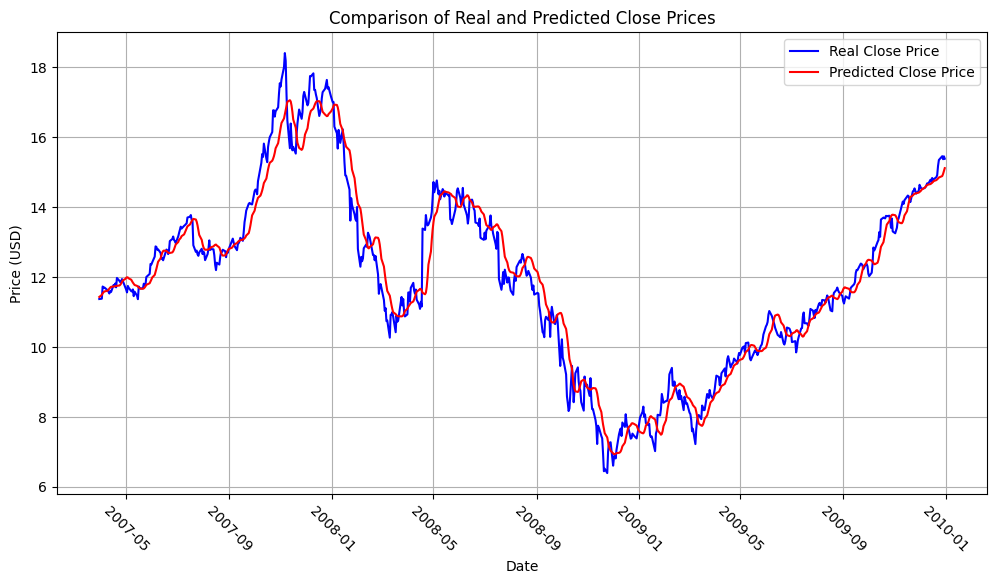

In [132]:
plt.figure(figsize=(12,6))


plt.plot(dates, new_data['Close'].iloc[lookback:].values, label='Real Close Price', color='blue')

plt.plot(dates, predictions_rescaled, label='Predicted Close Price', color='red')

plt.title('Comparison of Real and Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=-45)
plt.legend()
plt.grid()

plt.show()
